In [19]:
# =============================================
# TP5 - Pipeline de NLP (Tarefas 1→7)
# ——— Tarefas 1 a 4 integradas ———
# =============================================

from __future__ import annotations

# =========[SEÇÃO: IMPORTS ATUAIS — usados na Tarefa 1]=========
import os
import re
import json
import pickle
import string
from dataclasses import dataclass
from typing import Tuple, List, Dict, Any
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel

# =========[IMPORTS ADICIONAIS NECESSÁRIOS p/ Tarefas 3–4]=========
# (sem duplicações dos já existentes)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================
# [SEÇÃO A] Configurações gerais
# =============================================

SEMENTE_GLOBAL: int = 42
np.random.seed(SEMENTE_GLOBAL)

@dataclass(frozen=True)
class ConfigProjeto:
    caminho_csv: str = "IMDB Dataset.csv"
    coluna_texto: str = "review"
    coluna_alvo: str = "sentiment"
    salvar_dir: str = "./artefatos" 
    # Hiperparâmetros do TF-IDF (pensados para classificação e t-SNE;
    # LDA usará BoW específico na Tarefa 2)
    max_features_tfidf: int = 50000
    max_df: float = 0.9
    min_df: int | float = 5
    ngram_range: Tuple[int, int] = (1, 2)
    norm: str = "l2"
    stop_words: str | None = "english"
    lowercase: bool = True

CFG = ConfigProjeto()

# =============================================
# [SEÇÃO B] Pré-processamento textual
# =============================================

_regex_html = re.compile(r"<.*?>")
_regex_url  = re.compile(r"http\S+|www\.\S+")
_regex_num  = re.compile(r"\d+")
_tbl_traducao_punct = str.maketrans("", "", string.punctuation)

def limpar_texto(texto: str) -> str:
    """
    Limpeza leve para IMDB:
    - remove tags HTML, URLs, números, pontuação
    - normaliza espaços
    Evita stem/lemma nesta etapa para não atrapalhar análises futuras (ex.: LDA).
    """
    if not isinstance(texto, str):
        return ""
    t = texto
    t = _regex_html.sub(" ", t)
    t = _regex_url.sub(" ", t)
    t = _regex_num.sub(" ", t)
    t = t.translate(_tbl_traducao_punct)
    t = re.sub(r"\s+", " ", t, flags=re.MULTILINE).strip()
    return t

# =============================================
# [SEÇÃO C] Carregamento da base
# =============================================

def carregar_base(caminho: str, coluna_texto: str, coluna_alvo: str) -> pd.DataFrame:
    if not os.path.exists(caminho):
        raise FileNotFoundError(f"Base não encontrada em: {caminho}")
    df = pd.read_csv(caminho)
    colunas_necessarias = {coluna_texto, coluna_alvo}
    ausentes = colunas_necessarias - set(df.columns)
    if ausentes:
        raise ValueError(f"Colunas ausentes no CSV: {ausentes}")
    return df[[coluna_texto, coluna_alvo]].copy()

# =============================================
# [SEÇÃO D] TF-IDF (funções utilitárias p/ reuso em 2–7)
# =============================================

def criar_tfidf(textos: List[str], cfg: ConfigProjeto) -> tuple[TfidfVectorizer, Any]:
    """Ajusta TfidfVectorizer no corpus e retorna (vetorizador, X_tfidf)."""
    vetorizador = TfidfVectorizer(
        lowercase=cfg.lowercase,
        stop_words=cfg.stop_words,
        max_df=cfg.max_df,
        min_df=cfg.min_df,
        ngram_range=cfg.ngram_range,
        max_features=cfg.max_features_tfidf,
        norm=cfg.norm
    )
    X = vetorizador.fit_transform(textos)
    return vetorizador, X

def _salvar_vocab(vetorizador: TfidfVectorizer, cfg: ConfigProjeto) -> str:
    """Salva vocabulário ordenado pelo índice interno (termo→índice)."""
    vocab = pd.DataFrame({
        "termo": list(vetorizador.vocabulary_.keys()),
        "indice": list(vetorizador.vocabulary_.values())
    }).sort_values("indice").reset_index(drop=True)
    caminho = os.path.join(cfg.salvar_dir, "vocabulario_tfidf.csv")
    vocab.to_csv(caminho, index=False, encoding="utf-8")
    return caminho

def _salvar_stats_tfidf(vetorizador: TfidfVectorizer, X_esparsa, cfg: ConfigProjeto) -> str:
    """
    Salva estatísticas por termo:
      - df_estimado: nº de documentos em que o termo ocorre (após filtros)
      - idf: idf do scikit-learn (smooth_idf=True)
    Útil para EDA e ajuste de min_df/max_df.
    """
    termos = vetorizador.get_feature_names_out()
    df_obs = np.asarray((X_esparsa > 0).sum(axis=0)).ravel()
    idf = vetorizador.idf_
    stats = pd.DataFrame({"termo": termos, "df_estimado": df_obs, "idf": idf})
    caminho = os.path.join(cfg.salvar_dir, "tfidf_stats_full.csv")
    stats.to_csv(caminho, index=False, encoding="utf-8")
    return caminho

def _salvar_meta(X_esparsa, cfg: ConfigProjeto) -> str:
    """Salva metadados compactos da matriz TF-IDF (shape, nnz, densidade)."""
    meta = {
        "shape": [int(X_esparsa.shape[0]), int(X_esparsa.shape[1])],
        "nnz": int(X_esparsa.nnz),
        "densidade": float(X_esparsa.nnz / (X_esparsa.shape[0] * X_esparsa.shape[1]))
    }
    caminho = os.path.join(cfg.salvar_dir, "tfidf_meta.json")
    with open(caminho, "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)
    return caminho

def _salvar_vetorizador(vetorizador: TfidfVectorizer, cfg: ConfigProjeto) -> str:
    caminho = os.path.join(cfg.salvar_dir, "vetorizador_tfidf.pkl")
    with open(caminho, "wb") as f:
        pickle.dump(vetorizador, f)
    return caminho

def _salvar_mapeamento_classes(serie_alvo: pd.Series, cfg: ConfigProjeto) -> tuple[np.ndarray, str]:
    """
    Codifica y em inteiros estáveis (0/1) e salva o mapeamento para uso futuro
    (relatórios, explicabilidade, load de modelos).
    """
    cat = serie_alvo.astype("category")
    y_codes = cat.cat.codes.to_numpy()
    mapping = {int(i): str(lbl) for i, lbl in enumerate(cat.cat.categories)}
    caminho = os.path.join(cfg.salvar_dir, "classes_mapping.json")
    with open(caminho, "w", encoding="utf-8") as f:
        json.dump(mapping, f, ensure_ascii=False, indent=2)
    return y_codes, caminho

def salvar_artefatos_tfidf(vetorizador: TfidfVectorizer, X_esparsa, y_series: pd.Series, cfg: ConfigProjeto) -> Dict[str, str]:
    """
    Salva todos os artefatos necessários para as Tarefas 2–7:
      - vetorizador (PKL)
      - vocabulário (CSV termo→índice)
      - estatísticas por termo (CSV com df/idf)
      - metadados da matriz (JSON)
      - mapeamento de classes (JSON)
    (Matriz X NÃO é salva para evitar IO pesado.)
    """
    os.makedirs(cfg.salvar_dir, exist_ok=True)
    caminhos: Dict[str, str] = {}
    caminhos["vetorizador"] = _salvar_vetorizador(vetorizador, cfg)
    caminhos["vocabulario"] = _salvar_vocab(vetorizador, cfg)
    caminhos["stats_tfidf"] = _salvar_stats_tfidf(vetorizador, X_esparsa, cfg)
    caminhos["metadados"] = _salvar_meta(X_esparsa, cfg)
    _, mapping_path = _salvar_mapeamento_classes(y_series, cfg)
    caminhos["classes_mapping"] = mapping_path
    return caminhos

# =============================================
# [SEÇÃO E] Execução — Tarefa 1 (TF-IDF) pronta p/ 2–7
# =============================================

# 1) Carregar base
df_raw = carregar_base(CFG.caminho_csv, CFG.coluna_texto, CFG.coluna_alvo)

# 2) Limpar textos (mantém df['texto_limpo'] para LDA, t-SNE e explicabilidade)
df = df_raw.copy()
df["texto_limpo"] = df[CFG.coluna_texto].apply(limpar_texto)

# 3) Criar TF-IDF no corpus completo (usado por classificação, t-SNE e SHAP/LIME)
vetorizador_tfidf, X_tfidf = criar_tfidf(df["texto_limpo"].tolist(), CFG)

# 4) Codificar rótulos (estável) e salvar mapeamento
y_alvo = df[CFG.coluna_alvo].astype("category").cat.codes  # mantém 0/1 em memória

# 5) Salvar artefatos essenciais para reuso nas Tarefas 2–7
caminhos = salvar_artefatos_tfidf(vetorizador_tfidf, X_tfidf, df[CFG.coluna_alvo], CFG)

# 6) Relatórios rápidos (diagnóstico)
num_docs, num_feats = X_tfidf.shape
densidade = X_tfidf.nnz / (num_docs * num_feats)
classes_ordenadas = df[CFG.coluna_alvo].astype("category").cat.categories.tolist()

print("=== [Tarefa 1] TF-IDF concluída ===")
print(f"Documentos: {num_docs:,}")
print(f"Features (vocabulário): {num_feats:,}")
print(f"Densidade média da matriz: {densidade:.6f}")
print(f"Classes detectadas (ordem dos códigos 0..): {classes_ordenadas}")
print("\nArquivos salvos:")
for k, v in caminhos.items():
    print(f"- {k}: {v}")


=== [Tarefa 1] TF-IDF concluída ===
Documentos: 50,000
Features (vocabulário): 50,000
Densidade média da matriz: 0.002038
Classes detectadas (ordem dos códigos 0..): ['negative', 'positive']

Arquivos salvos:
- vetorizador: ./artefatos\vetorizador_tfidf.pkl
- vocabulario: ./artefatos\vocabulario_tfidf.csv
- stats_tfidf: ./artefatos\tfidf_stats_full.csv
- metadados: ./artefatos\tfidf_meta.json
- classes_mapping: ./artefatos\classes_mapping.json


In [20]:

# =============================================
# [SEÇÃO F] Tarefa 2 — Modelagem de Tópicos com LDA (robusta p/ memória)
# =============================================

import gc

class ConfigLDA:
    # candidatos de nº de tópicos
    candidatos_k = [10, 15, 20]

    # limites p/ reduzir custo na seleção de K
    amostra_docs_k = 10000            # usa até 10k docs para escolher K
    max_features_bow_k = 30000        # vocabulário p/ seleção de K
    min_df_k = 10
    max_df_k = 0.9

    # treino final (após escolher K)
    max_features_bow_final = 30000
    min_df_final = 10
    max_df_final = 0.9
    n_top_palavras = 12

    # hiperparâmetros LDA
    max_iter = 10
    learning_method_k = "batch"       # determinístico p/ seleção
    learning_method_final = "online"  # mais leve p/ treino final
    learning_decay = 0.7
    learning_offset = 10.0
    batch_size_final = 2048           # controla memória no online

CFG_LDA = ConfigLDA()

def _tokenize(texto: str) -> list[str]:
    return texto.lower().split()

# ---------- (1) Seleção de K com amostragem controlada ----------
df_k = df.sample(
    n=min(CFG_LDA.amostra_docs_k, len(df)),
    random_state=SEMENTE_GLOBAL
).reset_index(drop=True)

vectorizador_bow_k = CountVectorizer(
    lowercase=True,
    stop_words="english",
    max_df=CFG_LDA.max_df_k,
    min_df=CFG_LDA.min_df_k,
    max_features=CFG_LDA.max_features_bow_k
)
X_bow_k = vectorizador_bow_k.fit_transform(df_k["texto_limpo"].tolist())

tokens_corpus_k = [ _tokenize(t) for t in df_k["texto_limpo"].tolist() ]
dicionario_k = Dictionary(tokens_corpus_k)

def extrair_top_palavras(modelo_lda, vectorizer, n_top):
    termos = vectorizer.get_feature_names_out()
    topicos = []
    for k in range(modelo_lda.components_.shape[0]):
        pesos = modelo_lda.components_[k]
        idx = pesos.argsort()[-n_top:][::-1]
        topicos.append([termos[i] for i in idx])
    return topicos

resultados_coerencia = []
melhor_k, melhor_score, melhor_modelo_k = None, -np.inf, None

for k in CFG_LDA.candidatos_k:
    lda_k = LatentDirichletAllocation(
        n_components=k,
        max_iter=CFG_LDA.max_iter,
        learning_method=CFG_LDA.learning_method_k,
        learning_decay=CFG_LDA.learning_decay,
        learning_offset=CFG_LDA.learning_offset,
        random_state=SEMENTE_GLOBAL,
        evaluate_every=-1,
        verbose=0
    ).fit(X_bow_k)

    top_palavras_k = extrair_top_palavras(lda_k, vectorizador_bow_k, CFG_LDA.n_top_palavras)

    # Coerência c_v é pesada — calcular na amostra já reduz muito o custo
    cm = CoherenceModel(
        topics=top_palavras_k,
        texts=tokens_corpus_k,
        dictionary=dicionario_k,
        coherence="c_v"
    )
    score_cv = float(cm.get_coherence())
    resultados_coerencia.append({"k": int(k), "coerencia_c_v": score_cv})

    if score_cv > melhor_score:
        melhor_score, melhor_k, melhor_modelo_k = score_cv, k, lda_k

print("=== [Tarefa 2] LDA — Seleção de Tópicos (amostragem) ===")
for r in resultados_coerencia:
    print(f"K={r['k']:>2}  |  Coerência (c_v) = {r['coerencia_c_v']:.4f}")
print(f"\nMelhor K (amostra): {melhor_k}  (c_v={melhor_score:.4f})")

# Libera memória da etapa de seleção
del tokens_corpus_k, dicionario_k, X_bow_k, vectorizador_bow_k, melhor_modelo_k
gc.collect()

# ---------- (2) Treino final com método 'online' (mais leve) ----------
vectorizador_bow_final = CountVectorizer(
    lowercase=True,
    stop_words="english",
    max_df=CFG_LDA.max_df_final,
    min_df=CFG_LDA.min_df_final,
    max_features=CFG_LDA.max_features_bow_final
)
X_bow_final = vectorizador_bow_final.fit_transform(df["texto_limpo"].tolist())

lda_final = LatentDirichletAllocation(
    n_components=melhor_k,
    max_iter=CFG_LDA.max_iter,
    learning_method=CFG_LDA.learning_method_final,  # online
    batch_size=CFG_LDA.batch_size_final,
    learning_decay=CFG_LDA.learning_decay,
    learning_offset=CFG_LDA.learning_offset,
    random_state=SEMENTE_GLOBAL,
    evaluate_every=-1,
    verbose=0
).fit(X_bow_final)

topicos_melhor = extrair_top_palavras(lda_final, vectorizador_bow_final, CFG_LDA.n_top_palavras)
print("\nTop palavras por tópico (treino final):")
for i, palavras in enumerate(topicos_melhor, 1):
    print(f" - Tópico {i:02d}: {', '.join(palavras)}")

# ---------- (3) Salva artefatos ----------
os.makedirs(CFG.salvar_dir, exist_ok=True)

with open(os.path.join(CFG.salvar_dir, "vectorizador_bow.pkl"), "wb") as f:
    pickle.dump(vectorizador_bow_final, f)

with open(os.path.join(CFG.salvar_dir, "lda_model.pkl"), "wb") as f:
    pickle.dump(lda_final, f)

pd.DataFrame(
    {"topico": np.arange(1, len(topicos_melhor) + 1),
     "palavras": [", ".join(p) for p in topicos_melhor]}
).to_csv(os.path.join(CFG.salvar_dir, "lda_topicos.csv"), index=False, encoding="utf-8")

with open(os.path.join(CFG.salvar_dir, "lda_coerencia.json"), "w", encoding="utf-8") as f:
    json.dump(
        {"resultados": resultados_coerencia, "melhor_k": int(melhor_k), "coerencia_c_v": float(melhor_score)},
        f, ensure_ascii=False, indent=2
    )

# Libera memória pesada do LDA/BoW (para as próximas tarefas)
del X_bow_final
gc.collect()



=== [Tarefa 2] LDA — Seleção de Tópicos (amostragem) ===
K=10  |  Coerência (c_v) = 0.3579
K=15  |  Coerência (c_v) = 0.3375
K=20  |  Coerência (c_v) = 0.3447

Melhor K (amostra): 10  (c_v=0.3579)

Top palavras por tópico (treino final):
 - Tópico 01: film, role, cast, performance, best, great, good, plays, john, played, character, actor
 - Tópico 02: film, good, movie, films, like, horror, just, great, comedy, does, really, best
 - Tópico 03: western, match, comedy, cartoon, john, short, ford, big, time, good, westerns, funny
 - Tópico 04: series, characters, character, action, plot, good, story, episode, film, movie, like, original
 - Tópico 05: movie, great, like, love, time, just, good, years, watch, really, kids, old
 - Tópico 06: just, like, film, man, scene, gets, movie, guy, hes, bad, theres, woman
 - Tópico 07: war, game, world, american, space, soldiers, people, time, battle, earth, german, history
 - Tópico 08: film, story, life, films, movie, love, people, time, characters,

33

In [22]:
# =============================================
# [SEÇÃO G] Tarefa 3 — Classificação com tuning e CV (usa X_tfidf, y_alvo)
# =============================================
 
# Split treino/teste (estratificado)
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X_tfidf, y_alvo, test_size=0.2, random_state=SEMENTE_GLOBAL, stratify=y_alvo
)

# Validação cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEMENTE_GLOBAL)

# a) Regressão Logística
modelo_lr = LogisticRegression(max_iter=2000, solver="liblinear", random_state=SEMENTE_GLOBAL)
grid_lr = {
    "C": [0.25, 0.5, 1.0, 2.0, 4.0],
    "penalty": ["l1", "l2"]
}

# b) LinearSVC calibrado (permite probabilidades para ROC/AUC)


modelo_svc_cal = CalibratedClassifierCV(estimator=base_svc, cv=3, method="sigmoid")
grid_svc_cal = {
    "estimator__C": [0.25, 0.5, 1.0, 2.0, 4.0]
}

# c) MultinomialNB
modelo_nb = MultinomialNB()
grid_nb = {
    "alpha": [0.1, 0.5, 1.0, 2.0]
}

candidatos = [
    ("LogisticRegression", modelo_lr, grid_lr),
    ("LinearSVC_calibrado", modelo_svc_cal, grid_svc_cal),
    ("MultinomialNB", modelo_nb, grid_nb),
]

resultados_cv = []

def ajustar_com_grid(nome, estimador, param_grid):
    gscv = GridSearchCV(
        estimator=estimador,
        param_grid=param_grid,
        scoring="f1",
        n_jobs=-1,
        cv=skf,
        refit=True,
        verbose=0,
        return_train_score=False
    )
    gscv.fit(X_treino, y_treino)
    media_f1 = float(gscv.best_score_)
    resultados_cv.append({
        "modelo": nome,
        "melhores_params": gscv.best_params_,
        "f1_cv_media": media_f1
    })
    return gscv

gscv_modelos = {}
for nome, est, grid in candidatos:
    gscv_modelos[nome] = ajustar_com_grid(nome, est, grid)

# Seleciona melhor por F1-CV
melhor_nome = max(resultados_cv, key=lambda d: d["f1_cv_media"])["modelo"]
melhor_busca = gscv_modelos[melhor_nome]
melhor_estimador = melhor_busca.best_estimator_

print("=== [Tarefa 3] Resultados de CV (F1) ===")
for r in sorted(resultados_cv, key=lambda d: d["f1_cv_media"], reverse=True):
    print(f"{r['modelo']:<20} | F1-CV: {r['f1_cv_media']:.4f} | params: {r['melhores_params']}")
print(f"\n>> Melhor modelo: {melhor_nome} — params: {melhor_busca.best_params_}")


=== [Tarefa 3] Resultados de CV (F1) ===
LogisticRegression   | F1-CV: 0.8994 | params: {'C': 4.0, 'penalty': 'l2'}
LinearSVC_calibrado  | F1-CV: 0.8990 | params: {'estimator__C': 0.5}
MultinomialNB        | F1-CV: 0.8738 | params: {'alpha': 0.5}

>> Melhor modelo: LogisticRegression — params: {'C': 4.0, 'penalty': 'l2'}



=== [Tarefa 4] Métricas no TESTE ===
Acurácia : 0.9077
Precisão : 0.9015
Recall   : 0.9154
F1-Score : 0.9084
AUC-ROC  : 0.9668

Relatório de Classificação:

              precision    recall  f1-score   support

    negativo     0.9141    0.9000    0.9070      5000
    positivo     0.9015    0.9154    0.9084      5000

    accuracy                         0.9077     10000
   macro avg     0.9078    0.9077    0.9077     10000
weighted avg     0.9078    0.9077    0.9077     10000



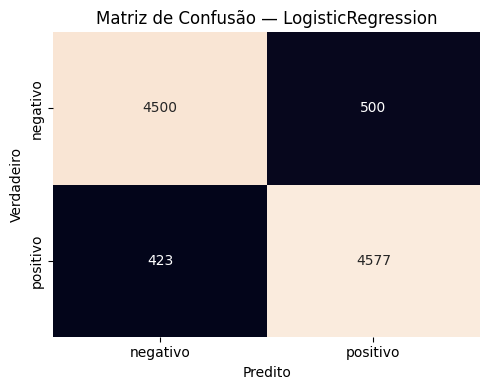

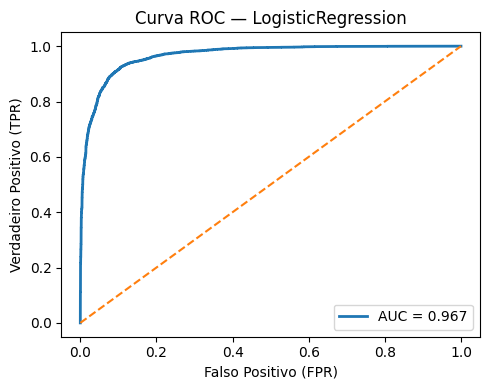

=== [Tarefa 1–4] Concluídas: TF-IDF + LDA + melhor classificador via CV + avaliação completa. ===


In [23]:

# =============================================
# [SEÇÃO H] Tarefa 4 — Avaliação no conjunto de teste
# =============================================

# Predições
y_pred = melhor_estimador.predict(X_teste)

# Probabilidades para ROC/AUC
if hasattr(melhor_estimador, "predict_proba"):
    y_proba = melhor_estimador.predict_proba(X_teste)[:, 1]
elif hasattr(melhor_estimador, "decision_function"):
    from sklearn.preprocessing import MinMaxScaler
    scores = melhor_estimador.decision_function(X_teste)
    y_proba = MinMaxScaler().fit_transform(scores.reshape(-1, 1)).ravel()
else:
    y_proba = y_pred.astype(float)

# Métricas
acc  = accuracy_score(y_teste, y_pred)
prec = precision_score(y_teste, y_pred, zero_division=0)
rec  = recall_score(y_teste, y_pred, zero_division=0)
f1   = f1_score(y_teste, y_pred, zero_division=0)
auc  = roc_auc_score(y_teste, y_proba)

print("\n=== [Tarefa 4] Métricas no TESTE ===")
print(f"Acurácia : {acc:.4f}")
print(f"Precisão : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC-ROC  : {auc:.4f}\n")

print("Relatório de Classificação:\n")
print(classification_report(y_teste, y_pred, target_names=["negativo", "positivo"], digits=4))

# Matriz de confusão
cm = confusion_matrix(y_teste, y_pred, labels=[0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False,
            xticklabels=["negativo", "positivo"], yticklabels=["negativo", "positivo"])
plt.title(f"Matriz de Confusão — {melhor_nome}")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.tight_layout()
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_teste, y_proba)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Falso Positivo (FPR)")
plt.ylabel("Verdadeiro Positivo (TPR)")
plt.title(f"Curva ROC — {melhor_nome}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print("=== [Tarefa 1–4] Concluídas: TF-IDF + LDA + melhor classificador via CV + avaliação completa. ===")


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.000s...
[t-SNE] Computed neighbors for 5000 samples in 0.172s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.058949
[t-SNE] KL divergence after 50 iterations with early exaggeration: 85.312363
[t-SNE] KL divergence after 1500 iterations: 3.006988


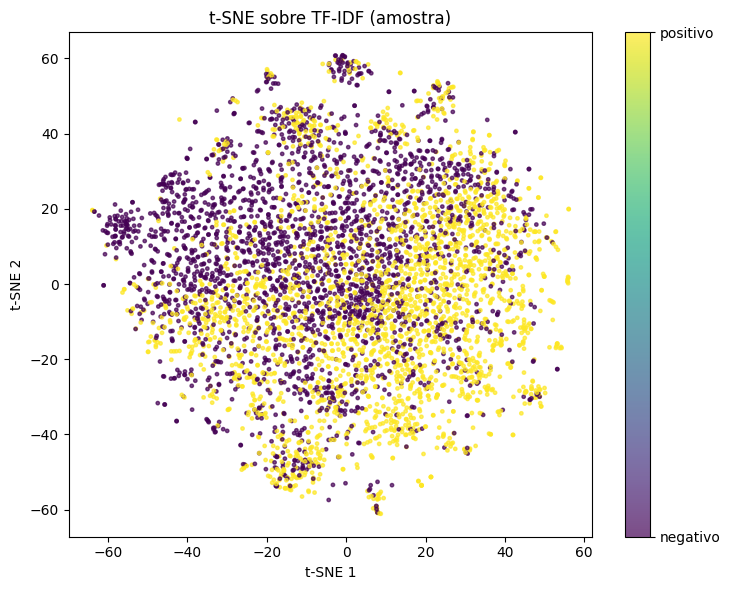

[Tarefa 5] Figura salva em: ./artefatos\tsne_tfidf_amostra.png


c:\Users\Afect\miniconda3\envs\nlp312\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
C:\Users\Afect\AppData\Local\Temp\ipykernel_3380\2451404012.py:152: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_exp, X_exp_dense, feature_names=termos, plot_type="bar", show=False)


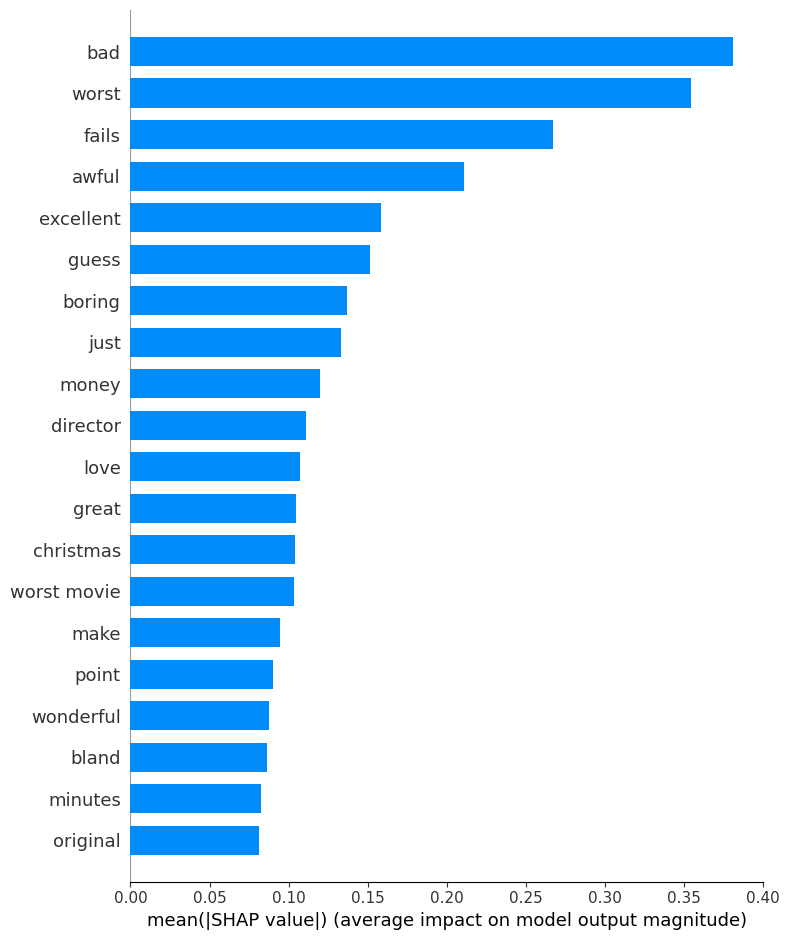

[Tarefa 6] SHAP summary (bar) salvo em: ./artefatos\shap_summary_bar.png
[Tarefa 6] SHAP force-plot agregado salvo (HTML): ./artefatos\shap_force_plot_agregado.html


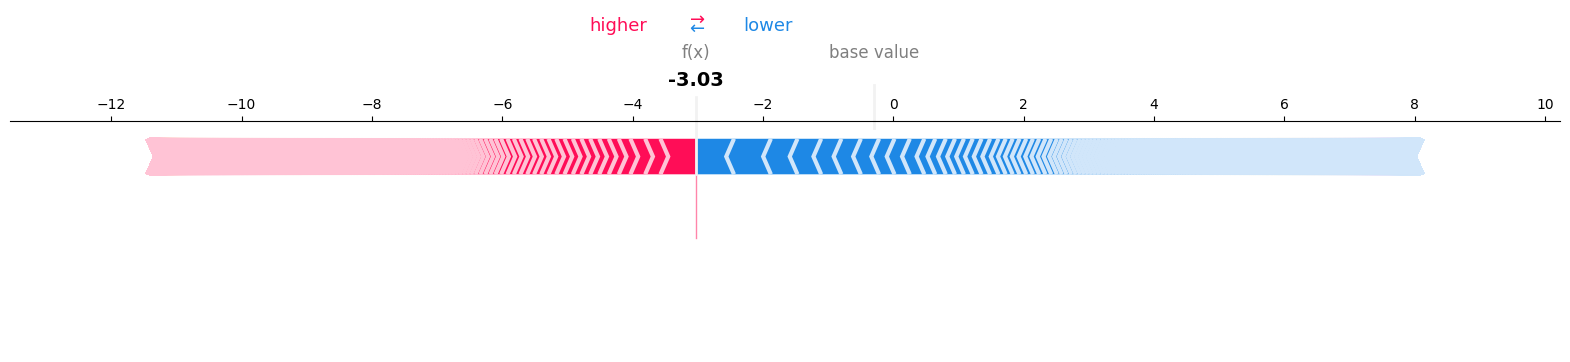

[Tarefa 6] Force-plot (instância 0) salvo: ./artefatos\shap_force_instancia_0.png | y_true=0 | y_pred=0


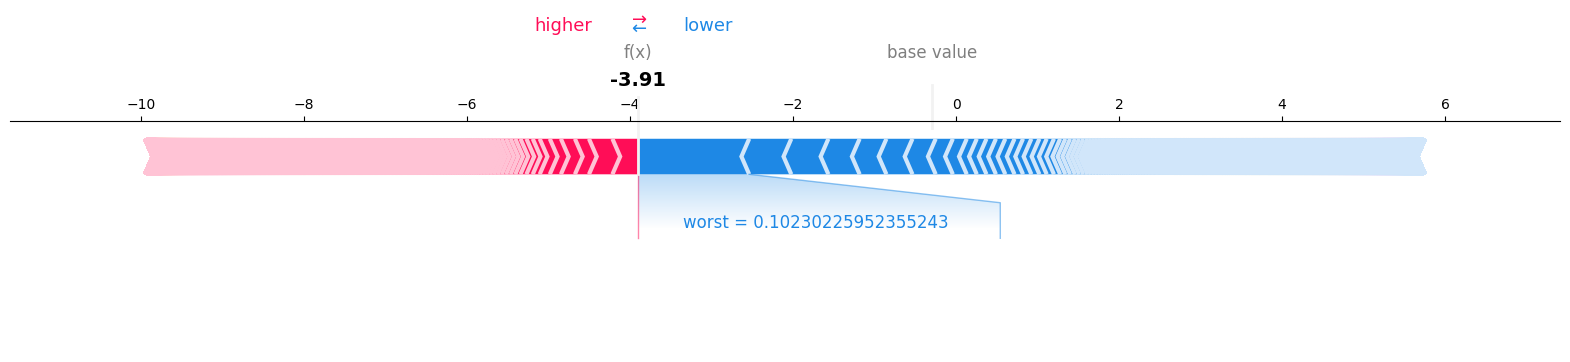

[Tarefa 6] Force-plot (instância 1) salvo: ./artefatos\shap_force_instancia_1.png | y_true=0 | y_pred=0


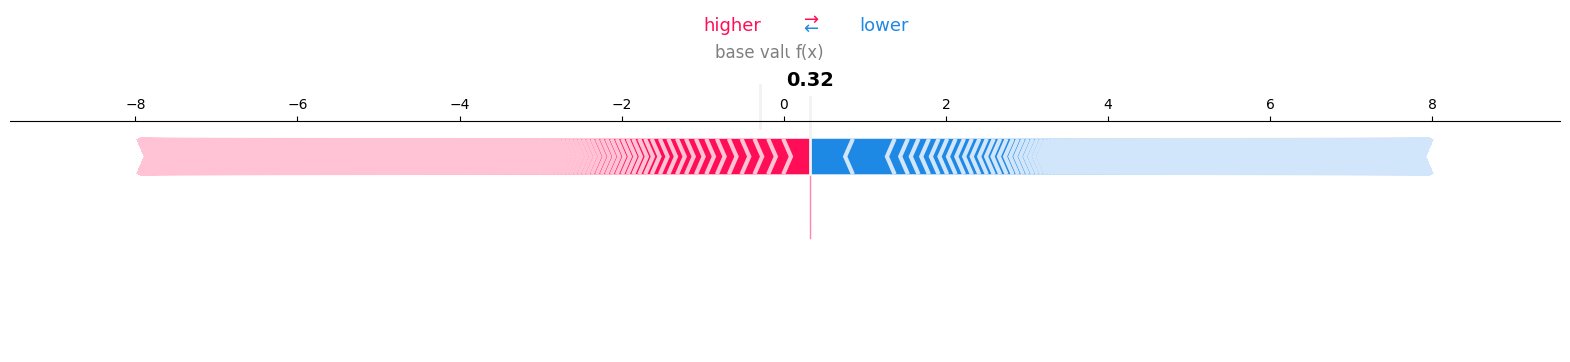

[Tarefa 6] Force-plot (instância 2) salvo: ./artefatos\shap_force_instancia_2.png | y_true=1 | y_pred=1
[Tarefa 6] LIME salvo em (HTML): ./artefatos\lime_explicacao_instancia0.html | y_true=0 | y_pred=0
=== [Tarefa 6] Concluída: SHAP (summary + force agregado/individuais) e LIME (texto). ===


In [24]:
# =============================================
# [SEÇÃO I] Tarefa 5 — Visualização com t-SNE (sobre TF-IDF)
# =============================================
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
os.makedirs(CFG.salvar_dir, exist_ok=True)

# ---- (1) Amostragem para custo controlado ----
n_amostra_tsne = min(5000, X_tfidf.shape[0])  # t-SNE é O(n^2)
idx_amostra = np.random.RandomState(SEMENTE_GLOBAL).choice(X_tfidf.shape[0], n_amostra_tsne, replace=False)
X_tfidf_amostra = X_tfidf[idx_amostra]
y_amostra = np.array(y_alvo)[idx_amostra]

# ---- (2) Pré-redução (SVD) + t-SNE 2D ----
svd = TruncatedSVD(n_components=50, random_state=SEMENTE_GLOBAL)
X_svd = svd.fit_transform(X_tfidf_amostra)

# Compatibilidade: novas versões usam 'max_iter'; antigas, 'n_iter'
try:
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate="auto",
        init="pca",
        random_state=SEMENTE_GLOBAL,
        max_iter=1500,    # versão nova (>=1.4)
        verbose=1
    )
except TypeError:
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate="auto",
        init="pca",
        random_state=SEMENTE_GLOBAL,
        n_iter=1500,      # fallback p/ versões antigas
        verbose=1
    )

X_tsne = tsne.fit_transform(X_svd)

# ---- (3) Plot 2D (colorido por classe real) ----
plt.figure(figsize=(7.5, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_amostra, s=6, alpha=0.7)
plt.title("t-SNE sobre TF-IDF (amostra)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.ax.set_yticklabels(["negativo", "positivo"])
plt.tight_layout()
caminho_tsne = os.path.join(CFG.salvar_dir, "tsne_tfidf_amostra.png")
plt.savefig(caminho_tsne, dpi=180)
plt.show()
print(f"[Tarefa 5] Figura salva em: {caminho_tsne}")
# =============================================
# [SEÇÃO J] Tarefa 6 — Explicabilidade: SHAP, Force-Plot e LIME
# =============================================
# Requisitos: 'shap' e 'lime' instalados (pip install shap lime)
try:
    import shap
except ImportError as e:
    raise ImportError("Instale as dependências com: pip install shap lime") from e

shap.initjs()

# ---- (1) Preparos: nomes de features e amostras para explicação ----
termos = vetorizador_tfidf.get_feature_names_out()

# Background pequeno para custo controlado (KernelExplainer)
n_bg = min(200, X_tfidf.shape[0])
idx_bg = np.random.RandomState(SEMENTE_GLOBAL + 1).choice(X_tfidf.shape[0], n_bg, replace=False)
X_bg = X_tfidf[idx_bg]
X_bg_dense = X_bg.toarray() if hasattr(X_bg, "toarray") else X_bg  # Kernel prefere denso

# Amostras a explicar individualmente
n_explicar = 5
idx_explicar = np.random.RandomState(SEMENTE_GLOBAL + 2).choice(X_tfidf.shape[0], n_explicar, replace=False)
X_exp = X_tfidf[idx_explicar]
X_exp_dense = X_exp.toarray() if hasattr(X_exp, "toarray") else X_exp  # plots exigem denso
textos_exp_raw = df.iloc[idx_explicar][CFG.coluna_texto].tolist()   # texto original para LIME
y_exp_true = np.array(y_alvo)[idx_explicar]

# Função robusta para probabilidades (binário)
def _predict_proba(m, X):
    if hasattr(m, "predict_proba"):
        return m.predict_proba(X)
    elif hasattr(m, "decision_function"):
        from sklearn.preprocessing import MinMaxScaler
        s = m.decision_function(X).reshape(-1, 1)
        p1 = MinMaxScaler().fit_transform(s).ravel()
        return np.vstack([1 - p1, p1]).T
    else:
        y = m.predict(X)
        return np.vstack([1 - y, y]).T

# ---- (2) SHAP: LinearExplainer p/ LogReg; caso contrário KernelExplainer ----
usa_linear = isinstance(melhor_estimador, LogisticRegression)
try:
    if usa_linear:
        explicador = shap.LinearExplainer(
            melhor_estimador,
            X_bg,                           # ok passar esparso aqui
            feature_perturbation="interventional"
        )
    else:
        raise ValueError("Forçando KernelExplainer para modelos não lineares.")
except Exception:
    explicador = shap.KernelExplainer(
        lambda X: _predict_proba(melhor_estimador, X)[:, 1],
        X_bg_dense                        # Kernel usa denso
    )

# ---- (3) Cálculo dos valores SHAP (compatível com APIs novas/antigas) ----
def _compute_shap_values(explicador, X):
    """
    Retorna (shap_values, base_value, is_list_por_classe)
    Funciona com .shap_values(X) (APIs antigas) e com explicador(X) (APIs novas).
    """
    base_val = None
    # Tenta API antiga
    try:
        if isinstance(explicador, shap.KernelExplainer):
            vals = explicador.shap_values(X, nsamples=200)  # limitar custo no Kernel
        else:
            vals = explicador.shap_values(X)                # LinearExplainer não aceita nsamples
        ev = getattr(explicador, "expected_value", getattr(explicador, "expected_values", None))
        if isinstance(ev, (list, np.ndarray)):
            base_val = float(np.array(ev).ravel()[-1])
        elif ev is not None:
            base_val = float(ev)
        return vals, base_val, isinstance(vals, list)
    except TypeError:
        # API nova: explicador(X) -> shap.Explanation (ou lista)
        exp = explicador(X)
        if isinstance(exp, list):
            vals = [e.values for e in exp]
            bvals = [np.array(e.base_values).ravel().mean() for e in exp]
            base_val = float(np.array(bvals).ravel()[-1])
            return vals, base_val, True
        else:
            vals = exp.values
            base_val = float(np.array(exp.base_values).ravel().mean())
            return vals, base_val, False

shap_values_exp, base_value, is_list = _compute_shap_values(explicador, X_exp_dense)

# ---- (4) Summary plot (agregado) — PNG ----
# shap.summary_plot cria a própria figura; salvamos a figura corrente.
if is_list:
    shap.summary_plot(shap_values_exp, X_exp_dense, feature_names=termos, plot_type="bar", show=False)
else:
    shap.summary_plot(shap_values_exp, X_exp_dense, feature_names=termos, plot_type="bar", show=False)

os.makedirs(CFG.salvar_dir, exist_ok=True)
caminho_summary = os.path.join(CFG.salvar_dir, "shap_summary_bar.png")
plt.gcf().savefig(caminho_summary, dpi=180, bbox_inches="tight")
plt.show()
print(f"[Tarefa 6] SHAP summary (bar) salvo em: {caminho_summary}")

# ---- (5) Force-plot agregado — HTML interativo (multi-amostras) ----
try:
    shap_vals_pos = shap_values_exp[-1] if is_list else shap_values_exp
    bv = base_value
    if bv is None:
        ev = getattr(explicador, "expected_value", getattr(explicador, "expected_values", 0.0))
        bv = float(np.array(ev).ravel()[-1]) if isinstance(ev, (list, np.ndarray)) else float(ev)

    force_multi = shap.force_plot(
        bv,
        shap_vals_pos,           # (n_amostras, n_features)
        X_exp_dense,             # valores das features (ajuda na leitura)
        feature_names=termos,
        matplotlib=False         # obrigatório para múltiplas amostras
    )
    caminho_force_html = os.path.join(CFG.salvar_dir, "shap_force_plot_agregado.html")
    try:
        shap.save_html(caminho_force_html, force_multi)
    except Exception:
        with open(caminho_force_html, "w", encoding="utf-8") as f:
            f.write(shap.getjs()); f.write(force_multi.html())
    print(f"[Tarefa 6] SHAP force-plot agregado salvo (HTML): {caminho_force_html}")
except Exception as e:
    print("[Tarefa 6] Aviso: não foi possível gerar o force-plot agregado:", repr(e))

# ---- (6) Force-plot individuais (PNG) para até 3 amostras ----
try:
    shap_vals_pos = shap_values_exp[-1] if is_list else shap_values_exp
    for i in range(min(n_explicar, 3)):
        shap.force_plot(
            bv,
            shap_vals_pos[i],
            X_exp_dense[i],
            feature_names=termos,
            matplotlib=True,
            show=False
        )
        caminho_force_i = os.path.join(CFG.salvar_dir, f"shap_force_instancia_{i}.png")
        plt.gcf().savefig(caminho_force_i, dpi=170, bbox_inches="tight")
        plt.show()
        y_pred_i = melhor_estimador.predict(X_exp[i]).item() if hasattr(X_exp, "shape") else melhor_estimador.predict([X_exp[i]]).item()
        print(f"[Tarefa 6] Force-plot (instância {i}) salvo: {caminho_force_i} | y_true={y_exp_true[i]} | y_pred={y_pred_i}")
except Exception as e:
    print("[Tarefa 6] Aviso: não foi possível gerar force-plots individuais:", repr(e))

# ---- (7) LIME (texto) — explicação local em HTML ----
try:
    from lime.lime_text import LimeTextExplainer
    class_names = ["negativo", "positivo"]

    def predict_proba_text(lista_textos):
        # Usa a mesma limpeza do pipeline
        X_local = vetorizador_tfidf.transform([limpar_texto(t) for t in lista_textos])
        return _predict_proba(melhor_estimador, X_local)

    explainer_lime = LimeTextExplainer(class_names=class_names)
    i0 = 0  # primeira instância da amostra
    exp_lime = explainer_lime.explain_instance(
        textos_exp_raw[i0],     # texto original (mais interpretável)
        predict_proba_text,
        num_features=10
    )
    caminho_lime = os.path.join(CFG.salvar_dir, "lime_explicacao_instancia0.html")
    exp_lime.save_to_file(caminho_lime)
    y_pred0 = melhor_estimador.predict(vetorizador_tfidf.transform([limpar_texto(textos_exp_raw[i0])])).item()
    print(f"[Tarefa 6] LIME salvo em (HTML): {caminho_lime} | y_true={y_exp_true[i0]} | y_pred={y_pred0}")
except Exception as e:
    print("[Tarefa 6] Aviso: LIME não pôde ser executado —", repr(e))

print("=== [Tarefa 6] Concluída: SHAP (summary + force agregado/individuais) e LIME (texto). ===")
